
**ÎÇ†Ïßú : 2023/ 03/ 09**

## Brief Intro : Kmeans and GMM Clustering plot

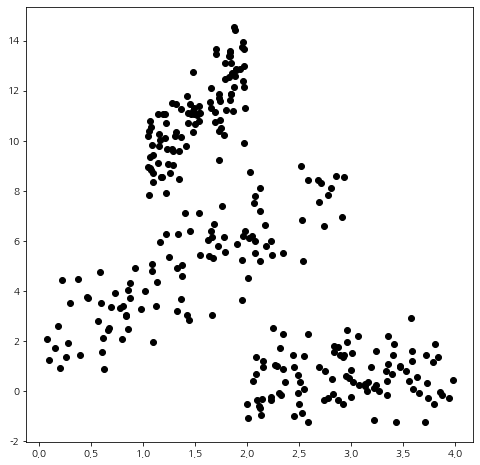

**Clustering by Kmeans** : Euclidian distanceÎ•º ÏÇ¨Ïö©Ìï¥ÏÑú Î∂ÑÏÇ∞Íµ¨Ï°∞Î•º Ï†úÎåÄÎ°ú Î∞òÏòÅÌïòÏßÄ Î™ªÌïúÎã§

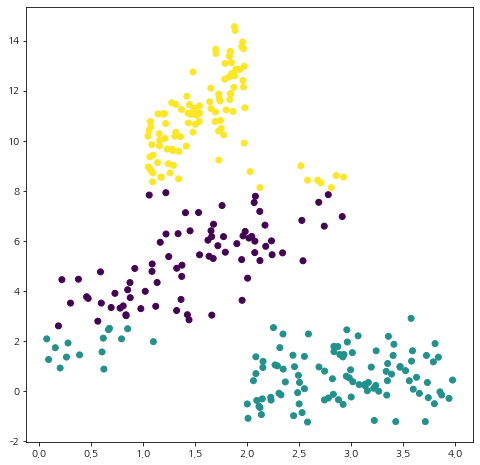

**Clustering by Gaussian Mixture Model**

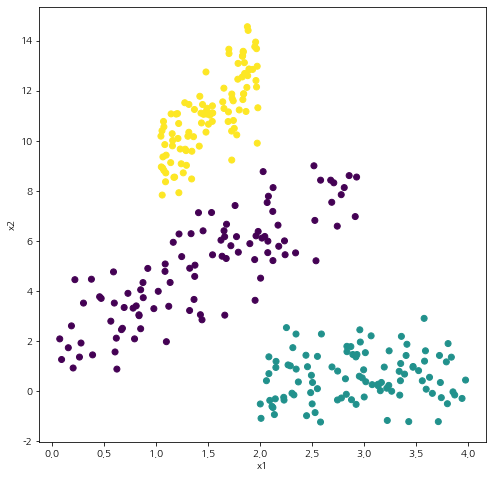

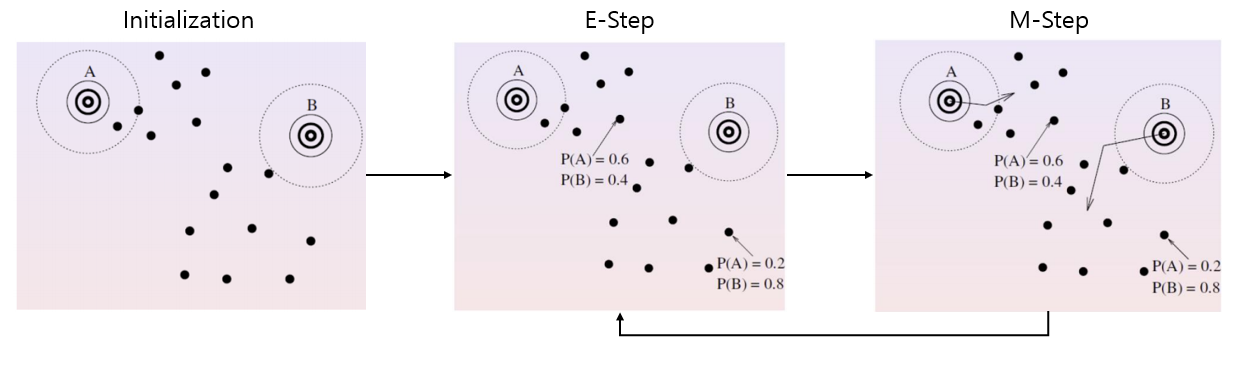

## Scratch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.special import logsumexp
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt


In [ ]:
data_unlabeled = pd.read_csv('/content/drive/MyDrive/unlabeled.csv')
x_unlabeled = data_unlabeled[["x1", "x2"]].values

In [ ]:
data_unlabeled.head()

x1     x2
0 -0.187  0.747
1  2.824  0.377
2  0.713  0.766
3  1.635  1.846
4  2.711  1.996

In [ ]:
x_unlabeled.shape

(1000, 2)

**TASK : cluster each customer to which they will like the product(y=1) or not(y=0).**

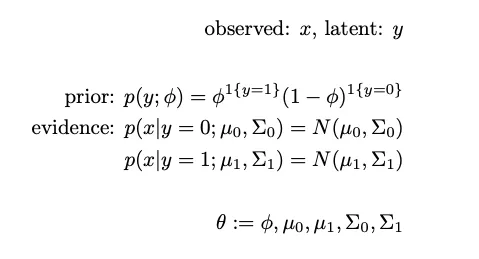

E-step Ìï®Ïàò ÏΩîÎìúÏóêÏÑú 1-piÍ∞Ä Î®ºÏ†Ä ÎÇòÏò§Îäî Ïù¥Ïú†

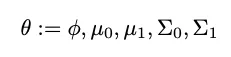

In [ ]:
# ÎßàÌï†ÎùºÎÖ∏ÎπÑÏä§ Í±∞Î¶¨ÏóêÏÑú Í≥µÎ∂ÑÏÇ∞ÌñâÎ†¨ Íµ¨Ìï†Îïå, Í≥µÎ∂ÑÏÇ∞ ÌñâÎ†¨Ïù¥ ÏñëÏùò Ï†ïÎ∂ÄÌò∏(Ïó¨Í∏∞ÏÑúÎäî semi) ÌñâÎ†¨Ïù¥ ÎêòÍ≤å ÌïúÎã§.
def get_random_psd(n):
  x = np.random.normal(0,1,size=(n,n))
  return np.dot(x,x.transpose())

# Í¥ÄÏã¨ Î™®ÏàòÎì§ÏùÑ ÎûúÎç§ Ï¥àÍ∏∞Í∞íÏúºÎ°ú ÏÑ∏ÌåÖÌïúÎã§.
def initialize_random_params():
  params = {'pi' : np.random.uniform(0,1), # selection probabilty of z_ik 
            'mu0' : np.random.normal(0,1,size=(2,)),
            'mu1' : np.random.normal(0,1,size=(2,)),
            'sigma0' : get_random_psd(2),
            'sigma1' : get_random_psd(2)}
  return params

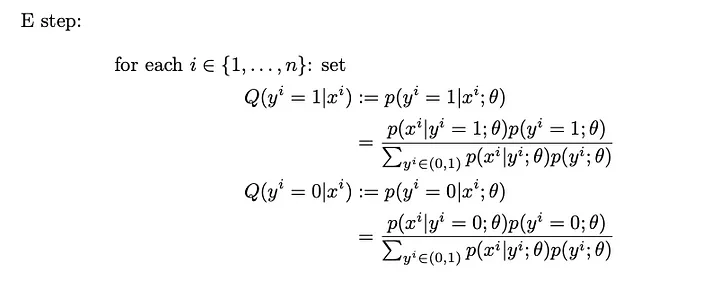

In [ ]:
# E-step : optimize q
# How? By setting q_t(z) = P(X|X,theta_t). Making KL(p||q) = 0 so that both dist. are 'identical'.
def e_step(x, params):
  np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
          stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)]) # likelihood of multivariate normal dist.
  log_p_y_x = np.log([1-params["pi"], params["pi"]])[np.newaxis, ...] + \
              np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
              stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(x)]).T
  log_p_y_x_norm = logsumexp(log_p_y_x, axis=1) # returns log of summed exponentials of inputs. 
  return log_p_y_x_norm, np.exp(log_p_y_x - log_p_y_x_norm[..., np.newaxis]) # Ïù¥Î∂ÄÎ∂ÑÏù¥ Ìó∑Í∞àÎ†∏ÎäîÎç∞, Î°úÍ∑∏ÌôîÌïòÎ©¥ Î∂ÑÎ™®Îäî ÎπºÎäî ÌòïÏãùÏúºÎ°ú Î≥ÄÌôòÎêòÍ∏∞ ÎïåÎ¨∏Ïóê Î∫Ä Í≤ÉÏù¥Îã§.

# Í∞Å elementÎßàÎã§ log likelihood, assignment probability(Q)Î•º Íµ¨Ìï¥Ï§å

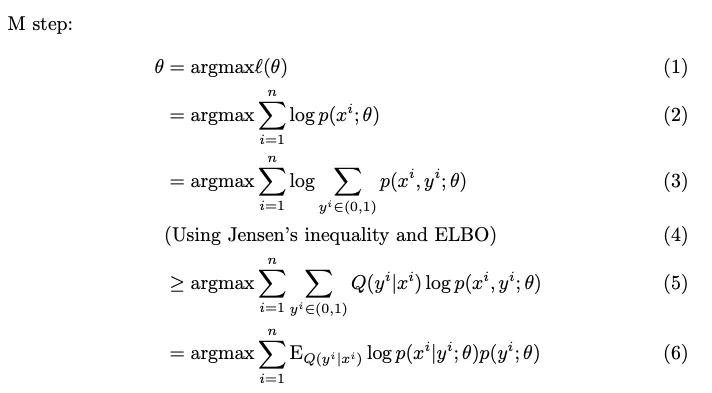

In [ ]:
# M-step : optimize parameter of interest
# How? By setting theta_(t+1) = ARGMAX theta E_qt(z)[ln P(X,Z|theta)]
def m_step(x, params):
    total_count = x.shape[0]
    _, heuristics = e_step(x, params)
    heuristic0 = heuristics[:, 0]
    heuristic1 = heuristics[:, 1]
    sum_heuristic1 = np.sum(heuristic1)
    sum_heuristic0 = np.sum(heuristic0)
    pi = (sum_heuristic1/total_count)
    mu0 = (heuristic0[..., np.newaxis].T.dot(x)/sum_heuristic0).flatten()
    mu1 = (heuristic1[..., np.newaxis].T.dot(x)/sum_heuristic1).flatten()
    diff0 = x - mu0
    sigma0 = diff0.T.dot(diff0 * heuristic0[..., np.newaxis]) / sum_heuristic0
    diff1 = x - mu1
    sigma1 = diff1.T.dot(diff1 * heuristic1[..., np.newaxis]) / sum_heuristic1
    params = {'pi': pi, 'mu0': mu0, 'mu1': mu1, 'sigma0': sigma0, 'sigma1': sigma1}
    return params

In [ ]:
def get_average_log_likelihood(x,params):
  loglikelihood, _ = e_step(x, params)
  return np.mean(loglikelihood)

def run_em(x,params):
  avg_loglikelihoods = []
  while True:
    avg_loglikelihood = get_average_log_likelihood(x,params)
    avg_loglikelihoods.append(avg_loglikelihood)
    if len(avg_loglikelihoods) > 2 and abs(avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0.0001: # setting break according to length of class, and set epsilon error bound.
      break
    params = m_step(x_unlabeled, params)
  print("\tpi: %s\n\tmu_0: %s\n\tmu_1: %s\n\tsigma_0: %s\n\tsigma_1: %s"
               % (params['pi'], params['mu0'], params['mu1'], params['sigma0'], params['sigma1']))
  
  _, posterior = e_step(x_unlabeled, params)
  forecasts = np.argmax(posterior, axis=1)
  return forecasts, posterior, avg_loglikelihoods

# posteriorÎäî assignment probabilityÏùò ÏµúÏ¢Ö version. ÍµêÏû¨ÏóêÏÑú ÎÇòÏò® notationÏúºÎ°ú ÌïòÎ©¥ q_inf(z)Ïóê Ìï¥ÎãπÌïòÎäî Î∂ÄÎ∂ÑÏûÑ
# np.argmaxÎäî Max Í∞íÏùò Ïù∏Îç±Ïä§Î•º Î∞òÌôòÌï®. Ïó¨Í∏∞ÏÑúÎäî Last E-StepÏùÑ Í±∞Ïπú assignment probabiltiryÍ∞Ä posterior. Ïï†Ï¥àÏóê r(z_ik):assignment probabilityÍ∞Ä posterior probabilityÏù¥Í∏∞ ÎïåÎ¨∏.

In [ ]:
random_params = initialize_random_params()
unsupervised_forecasts, unsupervised_posterior, unsupervised_loglikelihoods = run_em(x_unlabeled, random_params)
print("total steps:", len(unsupervised_loglikelihoods))


	pi: 0.997099693619678
	mu_0: [-1.531755    0.67798063]
	mu_1: [0.15152302 0.15801695]
	sigma_0: [[ 0.13182801 -0.01643974]
 [-0.01643974  0.00483802]]
	sigma_1: [[1.56950472 1.21593912]
 [1.21593912 1.48952396]]
total steps: 17


<ipython-input-65-6e0914b6d4d9>:4: RuntimeWarning: divide by zero encountered in log
  np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),
<ipython-input-65-6e0914b6d4d9>:7: RuntimeWarning: divide by zero encountered in log
  np.log([stats.multivariate_normal(params["mu0"], params["sigma0"]).pdf(x),


(stepÏùò Dist.Í∞Ä Îß§Ïö∞ random ÌñàÎã§. convergeÌïòÎäî ÏÜçÎèÑÍ∞Ä Îã§Î•∏Ìé∏Ïóê ÏÜçÌïòÎäîÎç∞ Ïú†ÏùòÎØ∏Ìïú ÏàòÏ§ÄÏùÄ ÏïÑÎãåÎìØÌï¥ÏÑú ÌÅ¨Í≤å Ïã†Í≤ΩÏì∞ÏßÄ ÏïäÍ≥† ÎÑòÏñ¥Í∞ê.)

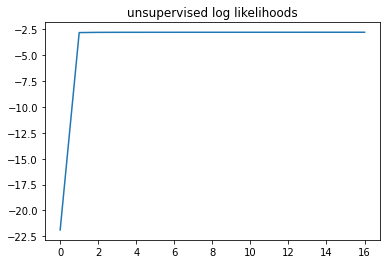

In [ ]:
plt.plot(unsupervised_loglikelihoods)
plt.title("unsupervised log likelihoods")
plt.savefig("unsupervised.png")
plt.show()

In [ ]:
unsupervised_posterior[0]

array([1.28252309e-08, 9.99999987e-01])

In [ ]:
unsupervised_forecasts[:20]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Using Scikit-Learn / Compare with labeled dataset 

**Ï†ÄÏûêÎäî Unsupervised learningÏùò ÌïôÏäµÏãúÍ∞ÑÏùò Í∏∏Ïù¥Î•º Îã®Ï†êÏúºÎ°ú ÏßÄÏ†ÅÌïòÏòÄÎã§. Unsupervised LearningÏùò Í≤ΩÏö∞ latent factor (pattern)ÏùÑ Ï∞æÎäîÎç∞ Ïò§Îûú ÏãúÍ∞ÑÏù¥ Í±∏Î¶¨ÎäîÎç∞, Ïù¥Îäî EM ÏïåÍ≥†Î¶¨Ï¶òÏùÑ ÏÇ¨Ïö©Ìïú GMM clusteringÏùò Îã®Ï†êÏúºÎ°ú ÏßÄÏ†ÅÎêòÍ∏∞ÎèÑ ÌïòÎäî Î∂ÄÎ∂ÑÏù¥Îã§.**

**Ïù¥Îü¨Ìïú Î∂ÄÎ∂ÑÏùÑ Ï†ÄÏûêÎäî, Semi-Supervised LearningÏùÑ ÌÜµÌï¥ Îã§ÏÜå Ìï¥Í≤∞Ìï† Ïàò ÏûàÎã§Í≥† Ï£ºÏû•ÌïúÎã§. Ïù¥Ïóê ÎåÄÌïú Í∑ºÍ±∞Î°úÎäî ÏïÑÎûò stepÏùò ÌöüÏàòÍ∞Ä 4~5Ìöå Ïù∏Í≤ÉÏúºÎ°ú, Unsupervised LearningÎ≥¥Îã§ stepÏùò ÏàòÍ∞Ä ÌòÑÏ†ÄÌûà Ï†ÅÎã§.**

**Ïù¥Í≤ÉÏù¥ Semi-Supervised LearningÏùò Ïû•Ï†êÏù¥Îã§. Warm StartÎ•º Ìï† Ïàò ÏûàÏñ¥ ÌïôÏäµÏãúÍ∞ÑÏùÑ Îã®Ï∂ïÏãúÌÇ¨Ïàò ÏûàÍ≥†, ÏàòÎ†¥ÏÜçÎèÑÍ∞Ä Îπ®ÎùºÏßÑÎã§. Ïù¥Îäî Îî•Îü¨ÎãùÏóêÏÑú lr_schedulingÏùÑ ÌÜµÌï¥ Íµ¨ÌòÑÎêòÍ∏∞ÎèÑ ÌïòÎäî Î∂ÄÎ∂ÑÏúºÎ°úÏÑú, epochÍ∞Ä Ï†ïÌï¥Ï†∏ÏûàÎäî Îî•Îü¨Îãù ÌïôÏäµÎ™®Îç∏ÏóêÏÑú lossÎ•º Ï°∞Í∏à Îçî minimizeÌï† Ïàò ÏûàÍ≤å Ìï¥Ï§ÄÎã§.**

(Îπ†Î•∏ ÏàòÎ†¥ÏÜçÎèÑÍ∞Ä ÌïÑÏöîÌïú ÎäêÎ¶∞ ÌïôÏäµÎ™®Îç∏Í∞ôÏùÄ Í≤ΩÏö∞Ïóê semi-supervised learningÏù¥ Ïû•Ï†êÏùÑ ÏßÄÎãêÍ≤ÉÏúºÎ°ú ÏòàÏÉÅÌñàÎã§. Í∑∏Îü¨ÎÇò, ÏàòÎ†¥ÏÜçÎèÑÍ∞Ä Îß§Ïö∞ Îπ†Î•∏ ÌïôÏäµÎ™®Îç∏Ïùò Í≤ΩÏö∞, overfittingÏùò Î¨∏Ï†úÎèÑ ÏÉùÍ∏∏Ïàò ÏûàÎã§Îäî ÏÉùÍ∞ÅÏù¥ Îì§Ïñ¥ÏÑú, warm startÍ∞Ä Î¨¥Ï°∞Í±¥Ï†ÅÏúºÎ°ú Ï¢ãÎã§Í≥†ÎßåÏùÄ Ìï†Ïàò ÏóÜÎäî issueÏù∏Í≤É Í∞ôÎã§.)

In [ ]:
data_labeled = pd.read_csv('/content/drive/MyDrive/labeled.csv')
x_labeled = data_labeled[["x1", "x2"]].values
y_labeled = data_labeled["y"].values

In [ ]:
def learn_params(x_labeled, y_labeled):
    n = x_labeled.shape[0]
    pi = x_labeled[y_labeled == 1].shape[0] / n
    mu0 = np.sum(x_labeled[y_labeled == 0], axis=0) / x_labeled[y_labeled == 0].shape[0]
    mu1 = np.sum(x_labeled[y_labeled == 1], axis=0) / x_labeled[y_labeled == 1].shape[0]
    sigma0 = np.cov(x_labeled[y_labeled == 0].T, bias= True)
    sigma1 = np.cov(x_labeled[y_labeled == 1].T, bias=True)
    return {'pi': pi, 'mu0': mu0, 'mu1': mu1, 'sigma0': sigma0, 'sigma1': sigma1}

	pi: 0.5863498817945461
	mu_0: [-1.04546727 -1.02704636]
	mu_1: [0.98763329 0.99661118]
	sigma_0: [[0.36018609 0.30853357]
 [0.30853357 0.75384027]]
	sigma_1: [[0.7196797  0.1437903 ]
 [0.1437903  0.30853791]]
total steps:  4


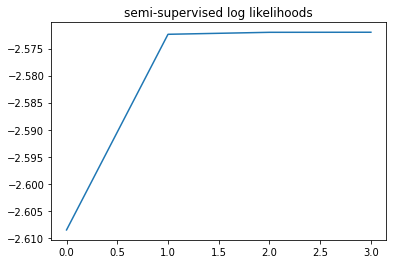

In [ ]:
learned_params = learn_params(x_labeled, y_labeled) # Îß§Ïö∞ Ï†ÅÏùÄ label dataÎ°ú random initial parameterÎ•º learned_paramsÎ°ú Î∞îÍøîÏ§å. ÏúÑÏóêÏÑú Ïñ∏Í∏â
semisupervised_forecasts, semisupervised_posterior, semisupervised_loglikelihoods = run_em(x_unlabeled, learned_params)
print("total steps: ", len(semisupervised_loglikelihoods))
plt.plot(semisupervised_loglikelihoods)
plt.title("semi-supervised log likelihoods")
plt.savefig("semi-supervised.png")

In [ ]:
def GMM_sklearn(x, weights=None, means=None, covariances=None):
    model = GaussianMixture(n_components=2,
                            covariance_type='full',
                            tol=0.01,
                            max_iter=1000,
                            weights_init=weights,
                            means_init=means,
                            precisions_init=covariances)
    model.fit(x)
    print("\nscikit learn:\n\tpi: %s\n\tmu_0: %s\n\tmu_1: %s\n\tsigma_0: %s\n\tsigma_1: %s"
               % (model.weights_[1], model.means_[0, :], model.means_[1, :], model.covariances_[0, :], model.covariances_[1, :]))
    return model.predict(x), model.predict_proba(x)[:,1]
  
  
learned_params = learn_params(x_labeled, y_labeled)
weights = [1 - learned_params["pi"], learned_params["pi"]]
means = [learned_params["mu0"], learned_params["mu1"]]
covariances = [learned_params["sigma0"], learned_params["sigma1"]]
sklearn_forecasts, posterior_sklearn = GMM_sklearn(x_unlabeled, weights, means, covariances)
output_df = pd.DataFrame({'semisupervised_forecasts': semisupervised_forecasts, 
                          'semisupervised_posterior': semisupervised_posterior[:, 1],
                          'sklearn_forecasts': sklearn_forecasts,
                          'posterior_sklearn': posterior_sklearn})
print("\n%s%% of forecasts matched." % (output_df[output_df["semisupervised_forecasts"] == output_df["sklearn_forecasts"]].shape[0] /output_df.shape[0] * 100))


scikit learn:
	pi: 0.5964789422680301
	mu_0: [-1.06169376 -1.0563389 ]
	mu_1: [0.96408565 0.98206315]
	sigma_0: [[0.35027155 0.29629092]
 [0.29629092 0.73083581]]
	sigma_1: [[0.74510804 0.16156928]
 [0.16156928 0.32021029]]

99.4% of forecasts matched.


üç† Conclusion

 **EM-GMMÏùÄ Unsupervised LearningÏúºÎ°ú classificationÌïòÎäî Î™©Ï†ÅÏóêÎèÑ ÏÇ¨Ïö©Îê† Ïàò ÏûàÎã§. Unsupervised LearningÏúºÎ°ú classificationÏùÑ ÌïòÎäî Î∞©Î≤ïÏùÄ Îã§ÏÜå ÏÉùÏÜåÌïòÏßÄÎßå Ïã†Í∏∞ÌïòÍ∏∞ÎèÑ ÌïòÎã§.**
 
 **Ïù¥Í≤å Í∞ÄÎä•Ìïú Ïù¥Ïú†Îäî multi-nomial dist.Î•º distribution selection probabilityÎ°ú ÏÇ¨Ïö©ÌïòÎäî Mixture ModelÏùò Ïª®ÏÖâÏù¥ Í≤∞Íµ≠, assignment probability (r_ik(z)) (posterior) Î°ú Í∑ÄÍ≤∞ÎêòÎäî Ïñ¥Îñ§ ÌÜµÍ≥ÑÏ†ÅÏù∏ Î∞©Î≤ïÎ°†ÏóêÏÑú Í∏∞Ïù∏ÌïòÍ∏∞ ÎïåÎ¨∏Ïù∏ÎìØ Ìï®.**

ü•î ÏïÑÏâ¨Ïö¥ Ï†ê

**GMMÏùÄ still Íµ∞ÏßëÏùò Í∞úÏàòÏù∏ K Í∞Ä ÏÇ¨Ïö©Ïûê ÏÑ§Ï†ïÏûÑ. Ïù¥Í≤ÉÏùÑ Ìï¥Í≤∞ÌïòÍ∏∞ ÏúÑÌï¥ Bayesian GMMÏù¥ ÏûàÎã§ÎäîÎç∞ Bayesian NonparametricÏóê ÎåÄÌïú Í≥µÎ∂ÄÍ∞Ä Ïñ¥ÎäêÏ†ïÎèÑ ÎêòÏñ¥ÏûàÏñ¥Ïïº ÌïúÎã§Í≥† Ìï®. ÎîîÎ¶¨ÌÅ¥Î†à Î∂ÑÌè¨Îûë Ìï¥Î∞ÄÌÑ¥ MCMCÎûë Ïù¥Í≤ÉÏ†ÄÍ≤É Ï†ÅÏö©Ìï¥ÏïºÎêòÎäî Î∂ÄÎ∂ÑÏù¥ ÏïÑÏßÅÏùÄ ÏÉùÏÜåÌïú Î∂ÄÎ∂ÑÏù¥ ÎßéÍ∏∞ ÎïåÎ¨∏Ïóê ÏùºÎã®ÏùÄ skip.**

**Bayesian ApproachÏùò Ï¢ãÏùÄÏ†ê**

1. K Í∞úÏàòÎ•º optimizeÌï† Ïàò ÏûàÏùå (Ïñ¥ÎñªÍ≤å?)

2. ÏÇ¨Ï†ÑÏßÄÏãù Î∞òÏòÅ Í∞ÄÎä•. mu, sigma, selection probability(pi)Ïóê ÏÇ¨Ï†ÑÏ†ïÎ≥¥ Î∞òÏòÅ Í∞ÄÎä•. Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÎäî ÏÉÅÌô©ÏóêÏÑú Îçî preciseÌïú ÏÑ±Îä• Í∞ÄÎä•(Íµ∞ÏßëÌôî, classification, anomaly detection TASKÏóêÏÑú)

## Additional Reference

1. https://lee-jaejoon.github.io/BNP-2/ Bayesian Finite Mixture Model

2. https://www.tensorflow.org/probability/examples/Bayesian_Gaussian_Mixture_Model?hl=ko Tensorflow Probability Í≥µÏãù ÌôàÌéòÏù¥ÏßÄ. 

    <Î≤†Ïù¥ÏßÄÏïà Í∞ÄÏö∞ÏãúÏïà ÌòºÌï© Î™®Îç∏ Î∞è Ìï¥Î∞ÄÌÑ¥ MCMC>

## GMM as Density Estimation

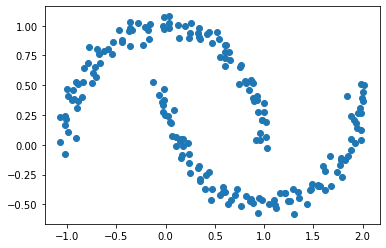

In [ ]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

In [ ]:
from sklearn.mixture import GaussianMixture as GMM
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0).fit(Xmoon)

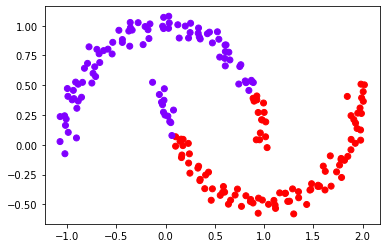

In [ ]:
gmm2_labels = gmm2.predict(Xmoon)
plt.scatter(Xmoon[:,0],Xmoon[:,1],c=gmm2_labels, cmap = 'rainbow')
plt.show()

Îã§Î≥ÄÎüâÏ†ïÍ∑úÎ∂ÑÌè¨Ï≤òÎüº Îç∞Ïù¥ÌÑ∞ÏÖãÏù¥ ÌÉÄÏõêÌòïÏúºÎ°ú plotÏóê Í∑∏Î†§ÏßÄÎäî multi-modal dataÎì§Ïóê ÎåÄÌï¥ÏÑúÎäî Ïûò ÏòàÏ∏°Ìï† Ïàò ÏûàÎã§. Í∑∏Îü¨ÎÇò ÏúÑÏôÄ Í∞ôÏù¥ ÌäπÏàòÌïú Í≤ΩÏö∞ÏóêÎäî Íµ∞ÏßëÌôîÍ∞Ä Ï†úÎåÄÎ°ú Ïù¥Î£®Ïñ¥ÏßÄÏßÄ ÏïäÏùÄ Í≤ÉÏùÑ Î≥º Ïàò ÏûàÎã§.

Ïù¥Îü¨Ìïú Ïù¥Ïú†Îäî, Ïù¥ Îç∞Ïù¥ÌÑ∞Î•º Íµ∞ÏßëÌôî Ìï†Îïå, Î∂ÑÏÇ∞Íµ¨Ï°∞Î•º Í≥†Î†§ÌïòÎäî Í≤É Î≥¥Îã§, Îç∞Ïù¥ÌÑ∞Îì§Ïùò sequential Ìïú Í±∞Î¶¨Í∞Ä Ï†ÅÏùÄ Í≤ÉÏùÑ ÌïòÎÇòÏùò Íµ∞ÏßëÏúºÎ°ú Í≥†Î†§Ìï¥ÏïºÌïòÍ∏∞ ÎïåÎ¨∏Ïù¥Îã§.

Ïù¥Î†áÎìØ Îç∞Ïù¥ÌÑ∞Ïùò ÌòïÌÉúÏóê Îî∞Îùº Îã§Î•∏ Íµ∞ÏßëÌôî Î∞©Î≤ïÎ°†ÏùÑ Ï†ÅÏö©ÏãúÌÇ§Îäî Í≤ÉÏù¥ Ï§ëÏöîÌï®.

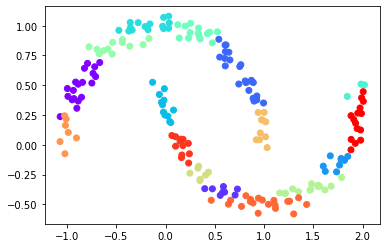

In [ ]:
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0).fit(Xmoon)
gmm16_labels = gmm16.predict(Xmoon)
plt.scatter(Xmoon[:,0],Xmoon[:,1],c=gmm16_labels, cmap = 'rainbow')
plt.show()

In [ ]:
Xnew = gmm16.sample(400)
pd.DataFrame.from_records(Xnew).transpose().drop(columns=[1],axis=1).head()
# plt.scatter(Xnew[:, 0], Xnew[:, 1])

0
0   [-0.9180243437995312, 0.4264852993499426]
1   [-0.7911479471556516, 0.7019832612276611]
2  [-1.0208538892585495, 0.22850745293935987]
3   [-0.8498637019168785, 0.4631601490657908]
4   [-0.7587088776364969, 0.6790701421598866]